# Theory Predictions and their Uncertainties

EOS can produce theory predictions for any of its built-in observables. The examples following in this section illustrate
1. how to find a specific observable from the list of all built-in observables;
2. manually construct an [eos.Observable](../reference/python.rst#eos.Observable) object and evaluate it to predict the observables (basic);
3. use an [analysis file](../reference/analysis-file-format.rst) to estimate the theoretical uncertainties associated with one or more observables (advanced).

## Listing the built-in Observables

The full list of built-in observables for the most-recent EOS release is available online [here](https://eos.github.io/doc/reference/observables). You can also show this list using the [eos.Observables](../reference/python.rst#eos.Observables) class. Searching for a specific observable is possible by filtering for specific strings in the observable name’s *prefix*, *name*, or *suffix* parts. The following example only shows observables that contain a `'B_c'` in the prefix part and `'BR'` in the name part.

You might need to click on the highlighted group heading "Observables in $B^-\to\ell^-\bar\nu$ decays" to expand it.

In [1]:
import eos
eos.Observables(prefix='B_c', name='BR')

The next example looks for `'B->Dlnu'` in the prefix part and `'BR'` in the name part.

Again, you might need to click on the highlighted group heading "Observables in $B\to \bar{D}\ell^-\bar\nu$ decays" to see the observables.

In [2]:
eos.Observables(prefix='B->Dlnu', name='BR')

## Constructing and Evaluating an Observable

The following is an example on how to interact with EOS at the most basic level. In the process, a few concepts will become clear. For a more elaborate example using Monte Carlo sampling techniques, see the next section.

To make theory predictions of any observable, EOS requires its full name, its [eos.Parameters](../reference/python.rst#eos.Parameters) object, its [eos.Kinematics](../reference/python.rst#eos.Kinematics) object, and its [eos.Options](../reference/python.rst#eos.Options) object. As a first example, we will use a very simple observable: the branching ratio of $B_c^-\to \ell^-\bar\nu$, which is represented by the name ``B_c->lnu::BR``, which was uncovered earlier. The ``B_c->lnu::BR`` is a well formed [eos.QualifiedName](../reference/python.rst#eos.QualifiedName), which is used throughout EOS to address observables and other objects. Additional information about any given observable can be obtained by displaying the full database entry, which also contains information about the kinematic variables required:

In [3]:
eos.Observables()['B_c->lnu::BR']

QualifedName,B_c->lnu::BR
Description,$$\mathcal{B}(B_c^- \to \ell^-\bar\nu)$$


Note that in the above we display a single observable by name using the ``[]`` operator.

From the above output we understand that the observable ``B_c->lnu::BR`` expects no kinematic variables (since none is listed).
We proceed to create an [eos.Observable](../reference/python.rst#eos.Observable) object for ``B_c->lnu::BR`` with the default set of parameters and options,
and then display it:

In [4]:
parameters = eos.Parameters.Defaults()
obs = eos.Observable.make('B_c->lnu::BR', parameters, eos.Kinematics(), eos.Options())
display(obs)

The default option ``l=mu`` select $\ell=\mu$ as the lepton flavour. The value of the observable is shown
to be about $9.8\cdot 10^{-5}$; unfortunately, no experiment has been able to see this decay to date.

By setting the ``l`` option to the value ``tau``, we create a different observable representing the $B_c^-\to \tau^-\bar\nu$ branching ratio:

In [5]:
obs = eos.Observable.make('B_c->lnu::BR', parameters, eos.Kinematics(), eos.Options(l='tau'))
display(obs)

The new observable yields a value of $2.4\%$.


So far we have only evaluated an observable without kinematic dependence.
To change this up, we will now transition to the second example, the differential branching fraction for $\bar{B}\to D\ell^-\bar\nu$ accessible through the name ``B->Dlnu::dBR/dq2``.


In [6]:
eos.Observables()['B->Dlnu::dBR/dq2']

QualifedName,B->Dlnu::dBR/dq2
Description,$$d\mathcal{B}(\bar{B}\to D\ell^-\bar\nu)/dq^2$$
Kinematic Variables,q2


The differential branching fraction is accessible just as we did before, with the exception of providing the kinematic variables through an [eos.Kinematics](../reference/python.rst#eos.Kinematics) object.

In [7]:
obs = eos.Observable.make('B->Dlnu::dBR/dq2', parameters, eos.Kinematics(q2=4.0), eos.Options(l='tau'))
display(obs)

This is not very helpful, since we can only look into a single observable at a single kinematic point at a time. To better illustrate the differential branching ratio,
we use EOS's plot functions:

Handling item to plot B->Dlnu::dBR/dq2


Handling item to plot B->Dlnu::dBR/dq2


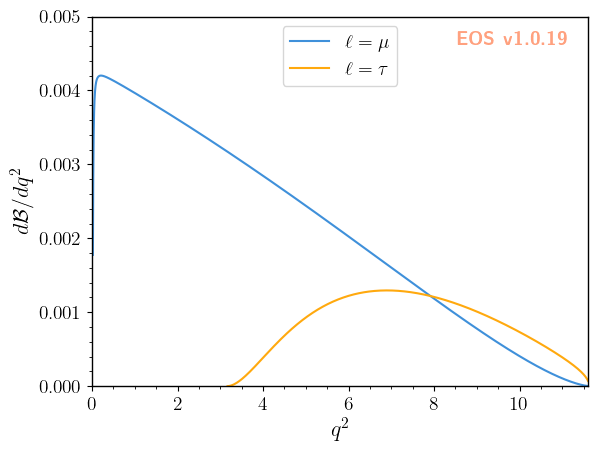

In [8]:
figure_args = """
plot:
  legend: { position: 'upper center' }
  xaxis: { label: '$q^2$',                range: [0.0, 11.6]   }
  yaxis: { label: '$d\\mathcal{B}/dq^2$', range: [0.0, 5.0e-3] }
  items:
  - { type: 'observable', observable: 'B->Dlnu::dBR/dq2', options: { 'l': 'mu' },  label: '$\\ell = \\mu$',
      variable: 'q2', range: [0.02, 11.6], resolution: 5800
    }
  - { type: 'observable', observable: 'B->Dlnu::dBR/dq2', options: { 'l': 'tau' }, label: '$\\ell = \\tau$',
      variable: 'q2', range: [3.17, 11.6], resolution: 421
    }
"""
figure = eos.figure.FigureFactory.from_yaml(figure_args)
figure.draw()

The above shows two differential branching ratios: one for $\ell = \mu$ and one for $\ell=\tau$. The two are distinguished by specifying the `'l'` option which is provided via the ``options`` entry in each plot item. It could also be provided as part of each observable's qualified name (i.e., by appending ``;l=mu`` or ``;l=tau`` to the values in ``observable``).

## Estimating Theory Uncertainties

To estimate theoretical uncertainties of an observable $O$, EOS uses Bayesian statistics.
Bayesian Statistics interprets the theory parameters as random variables $\vec\vartheta$ and assigns *a priori*
probability density functions (prior PDFs) for each parameter, $P_0(\vec\vartheta)$.
Random variates of the observables should then be distributed $O \sim P_{0,O}$, where
$$
    P_{0,O}(o) = \int d^N\vartheta \delta(O(\vec\vartheta) - o) \, P_0(\vec\vartheta)
$$
with $N=\dim \vec\vartheta$. We call $P_{0,O}(o)$ the prior-predictive distribution.

In many cases, the prior PDF $P_0(\vec\vartheta)$ is not readily available. Instead, only theoretical likelihoods $P(\text{data}|\vec\vartheta)$ are available.
In those case, we can use Bayes theorem to obtain the *a posteriori* PDF via
$$
    P(\vec\vartheta|\text{data}) = \frac{P(\text{data}|\vec\vartheta) P_0(\vec\vartheta)}{P(\text{data})}\,.
$$
The definition of a posterior-predictive distribution then reads
$$
    P_{O}(o) = \int d^N\vartheta \delta(O(\vec\vartheta) - o) \, P(\vec\vartheta|\text{data})
$$

EOS provides the means to draw and store Monte Carlo samples for a prior PDF $P_0(\vec\vartheta)$, a posterior PDF $P(\vec\vartheta|\text{data})$, and predictive distributions. We store this data within a hierarchy of directories below a "base directory". For the purpose of the following examples, we set this base directory to ``./predictions-data``, stored in a convenient global variable.

In [9]:
EOS_BASE_DIRECTORY='./predictions-base'

We continue with the first example from earlier: the branching ratio of $\bar{B}_c^- \to \ell^-\bar\nu$ decays. To leading order in $\alpha_e$, the decay amplitude is parametrized in terms of a single hadronic matrix element. The latter is known as the $B_c$ decay constant $f_{B_c}$, which is available within EOS as the parameter with qualified name `decay-constant::B_c`:

In [10]:
eos.Parameters()['decay-constant::B_c']

$$f_{B_c^\pm}$$,(eos.Parameter)
current value,0.434
default value,0.434


We assume Gaussian prior distributions for the decay constants of the $B_c$ meson with central value $0.434\,\text{GeV}$ and standard deviation $0.043\,\text{GeV}$.
We specify the prior through the following contents of an analysis file:
```yaml
priors:
  - name: DecayConstant
    descriptions:
      - { parameter: 'decay-constant::B_c',      min:  0.219, max: 0.649, type: 'gaussian', central: 0.434, sigma: 0.043 }
  # ...

posteriors:
  - name: DecayConstant
    prior:
      - DecayConstant
    likelihood: []
  # ...

predictions:
  - name: Bc-to-tau-nu
    observables:
      - name: B_c->lnu::BR;l=tau
  # ...
```
The range ``min`` to ``max`` is chosen to contain +/-5 standard deviations of the Gaussian bell curve. The above is a snippet of the accompanying file ``predictions.yaml``.

To draw samples from the (fake) posterior ``DecayConstant``, we use EOS ``tasks`` framework. A task is a repeatedly used piece of code that can rely on the output of previous tasks and store its results for following tasks or further processing with custom Python code.

The task to draw random samples from a (fake) posterior that contains only prior information and no likelihood is called ``sample_prior``. It is called as follows within Python:

In [11]:
eos.tasks.sample_prior('./predictions.yaml', 'DecayConstant', base_directory=EOS_BASE_DIRECTORY, N=2000, seed=42)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('data/DecayConstant/samp…

As a result of running this task, the contents of our base directory now looks as follows:

In [12]:
!tree ./predictions-base

./predictions-base
└── data
    └── DecayConstant
        └── samples
            ├── description.yaml
            ├── log
            ├── samples.npy
            └── weights.npy

3 directories, 4 files


If needed, we can inspect these samples by loading them from disk. This is achieved through the ``eos.data.ImportanceSamples`` class. For example, we can use it to confirm that indeed 2000 samples have been produced:

In [13]:
output = eos.data.ImportanceSamples(EOS_BASE_DIRECTORY + '/data/DecayConstant/samples')
display(output.samples.shape)

(2000, 1)

We can now pass the previously-obtained prior samples to the ``predict-observables`` task, thereby producing samples of the prior-predictive PDF for the observable at hand:

In [14]:
eos.tasks.predict_observables('./predictions.yaml', 'DecayConstant', 'Bc-to-tau-nu', base_directory=EOS_BASE_DIRECTORY)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('data/DecayConstant/pred…

The resulting prior-samples are stored in a directory named for the prediction set (``pred-Bc-to-tau-nu``) within the posterior directory (``DecayConstant``):

In [15]:
!tree ./predictions-base

./predictions-base
└── data
    └── DecayConstant
        ├── pred-Bc-to-tau-nu
        │   ├── description.yaml
        │   ├── log
        │   ├── samples.npy
        │   └── weights.npy
        └── samples
            ├── description.yaml
            ├── log
            ├── samples.npy
            └── weights.npy

4 directories, 8 files


We can inspect the so-obtained predictive samples using the ``eos.data.Prediction`` class. The following code loads the samples from disk and compute the (weighted) average and standard deviation:

In [16]:
import numpy as np
prediction = eos.data.Prediction(EOS_BASE_DIRECTORY + '/data/DecayConstant/pred-Bc-to-tau-nu')
avg = np.average(prediction.samples[:, 0], weights=prediction.weights, axis=0)
std = np.sqrt(np.average((prediction.samples[:, 0] - avg)**2, weights=prediction.weights, axis=0))
print(f'BR(B_c->tau nu) = {100 * avg:.2f} +/- {100 * std:.2f} %')

BR(B_c->tau nu) = 2.39 +/- 0.47 %


We carry on using the previously shown second example: the integrated branching ratios of $\bar{B}^-\to D^0\left\lbrace\mu^-, \tau^-\right\rbrace\bar\nu$ decays.
The largest source of theoretical uncertainty in these decays arises from the hadronic matrix elements, i.e.,
from the form factors $f^{B\to \bar{D}}_+(q^2)$ and $f^{B\to \bar{D}}_0(q^2)$.
Both form factors have been obtained independently using lattice QCD simulations by the HPQCD and Fermilab/MILC (FNAL+MILC) collaborations.
No prior PDF $P_0$ is available; hence, we have to construct a suitable likelihood.
We construct a joint likelihood for both form factors at different $q^2$ values. To do so, we use both of these predictions, which are available in EOS as `Constraint` objects under the names ``B->D::f_++f_0@HPQCD2015A`` and ``B->D::f_++f_0@FNAL+MILC2015B``.

To use these constraints, we must first decide how to parametrize the form factors.
For what follows we will use a simplified series expansion (abbreviated SSE) up to order $N = 2$.
The form factors are written as ([BFW:2010A], [BSZ:2015A]): $$f_i(z) = \frac{1}{1 - q^2/m_{R_i}^2} \sum_{k=0}^N \alpha^{f_i}_k z^k \, , \qquad \text{with } z(q^2, t_0) = \frac{\sqrt{t_+ - q^2} - \sqrt{t_+ - t_0}}{\sqrt{t_+ - q^2} + \sqrt{t_+ - t_0}}.$$

We specify the posterior with this combined likelihood through the following contents of an analysis file:
```yaml
priors:
  # other prior components
  - name: FF-SSE
    descriptions:
        { parameter: 'B->D::alpha^f+_0@BSZ2015', min:  0.0, max:  1.0, type: 'uniform' }
        { parameter: 'B->D::alpha^f+_1@BSZ2015', min: -5.0, max: +5.0, type: 'uniform' }
        { parameter: 'B->D::alpha^f+_2@BSZ2015', min: -5.0, max: +5.0, type: 'uniform' }
        { parameter: 'B->D::alpha^f0_1@BSZ2015', min: -5.0, max: +5.0, type: 'uniform' }
        { parameter: 'B->D::alpha^f0_2@BSZ2015', min: -5.0, max: +5.0, type: 'uniform' }

likelihoods:
  - name: FF-LQCD
    constraints:
      - 'B->D::f_++f_0@HPQCD:2015A'
      - 'B->D::f_++f_0@FNAL+MILC:2015B'

posteriors:
  # other posteriors
  - name: FF-LQCD-SSE
    global_options:
      form-factors: BSZ2015
    prior:
      - FF-SSE
    likelihood:
      - FF-LQCD

predictions:
  # other predictions
  - name: B-to-D-mu-nu
    observables:
      - name: B->Dlnu::dBR/dq2;l=mu
        kinematics: [ { q2:  0.02 }, { q2:  0.05 }, { q2:  0.10 }, { q2:  0.15 }, { q2:  0.20 }, { q2:  0.25 },
                      { q2:  0.30 }, { q2:  0.35 }, { q2:  0.40 }, { q2:  0.45 }, { q2:  0.50 }, { q2:  0.55 },
                      { q2:  0.60 }, { q2:  0.65 }, { q2:  0.70 }, { q2:  0.75 }, { q2:  0.80 }, { q2:  0.85 },
                      { q2:  0.90 }, { q2:  0.95 }, { q2:  1.0  }, { q2:  1.5  }, { q2:  2.0  }, { q2:  2.5  },
                      { q2:  3.0  }, { q2:  4.0  }, { q2:  5.0  }, { q2:  6.0 }, { q2:  7.0 }, { q2:  8.0 },
                      { q2:  9.0  }, { q2: 10.0  }, { q2: 11.0  }, { q2: 11.6 } ]

  - name: B-to-D-tau-nu
    observables:
      - name: B->Dlnu::dBR/dq2;l=tau
        kinematics: [ { q2:  3.2  }, { q2:  4.0 }, { q2:  5.0 }, { q2:  6.0 }, { q2:  7.0 }, { q2:  8.0 },
                      { q2:  9.0  }, { q2: 10.0 }, { q2: 11.0 }, { q2: 11.6 } ]
```

In the above, we made sure to provide the option `form-factors=BSZ2015` to ensure that the right form factor parametrization is used.

As before, the first step is to sample from the log(posterior). To sample from an intractable posterior PDF, EOS provides the ``sample-nested`` tasks that interfaces with the ``dynesty`` software.
The latter implements black-box posterior sampling by means of the dynamical nested sampling algorithm. The latter requires as controlling input the number of live points (``nlive``) and a threshold for the estimate of the remaining log evidence (``dlogz``). Increasing the former or decreasing the latter will lead to a larger number of importance samples and a longer sampling time.
We refer to the ``dynesty`` documentation for a detailed explanation of both quantities.


A typical call to ``sample-nested`` reads:

In [17]:
eos.tasks.sample_nested('predictions.yaml', 'FF-LQCD-SSE', base_directory=EOS_BASE_DIRECTORY, nlive=250, dlogz=0.5, seed=42)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('data/FF-LQCD-SSE/nested…

The state of our base directory for storing the associated data now looks as follows:

In [18]:
!tree -L 2 ./predictions-base

./predictions-base
└── data
    ├── DecayConstant
    └── FF-LQCD-SSE

3 directories, 0 files


The posterior samples at hand, we can then produce the posterior-predictive samples as before, using the ``predict-observables`` task for our two prediction sets ``B-to-D-mu-nu`` and ``B-to-D-tau-nu``:

In [19]:
eos.tasks.predict_observables('predictions.yaml', 'FF-LQCD-SSE', 'B-to-D-mu-nu',  base_directory=EOS_BASE_DIRECTORY)
eos.tasks.predict_observables('predictions.yaml', 'FF-LQCD-SSE', 'B-to-D-tau-nu', base_directory=EOS_BASE_DIRECTORY)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('data/FF-LQCD-SSE/pred-B…

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('data/FF-LQCD-SSE/pred-B…

Using the EOS plotting framework, we readily illustrate the posterior-predictive distributions as functions of the momentum transfer $q^2$:

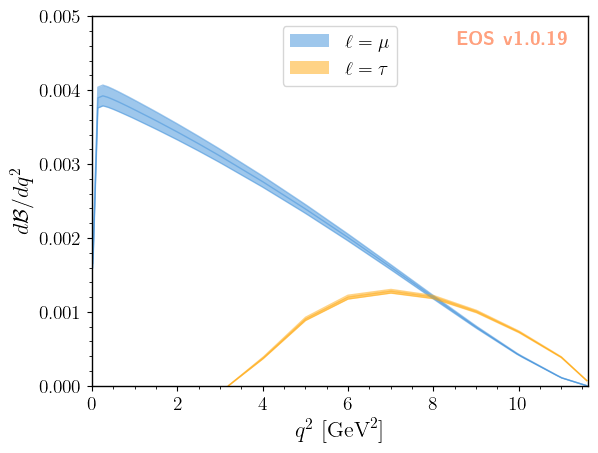

In [20]:
figure_args = """
plot:
  xaxis: { label: '$q^2$', unit: '$\\textnormal{GeV}^2$', range: [0.0, 11.63] }
  yaxis: { label: '$d\\mathcal{B}/dq^2$',                 range: [0.0,  5e-3] }
  legend: { position: 'upper center' }
  items:
    - { type: 'uncertainty', label: '$\\ell=\\mu$',
        variable: 'q2', range: [0.02, 11.63],
        datafile: './predictions-base/data/FF-LQCD-SSE/pred-B-to-D-mu-nu'
      }
    - { type: 'uncertainty', label: '$\\ell=\\tau$',
        variable: 'q2', range: [3.17, 11.63], resolution: 1000,
        datafile: './predictions-base/data/FF-LQCD-SSE/pred-B-to-D-tau-nu'
      }
"""
figure = eos.figure.FigureFactory.from_yaml(figure_args)
figure.draw()

Alternatively, one might be inclined to produce predictions for the $q^2$-binned branching ratio:

In [21]:
eos.tasks.predict_observables('predictions.yaml', 'FF-LQCD-SSE', 'B-to-D-mu-nu-binned', base_directory=EOS_BASE_DIRECTORY)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('data/FF-LQCD-SSE/pred-B…

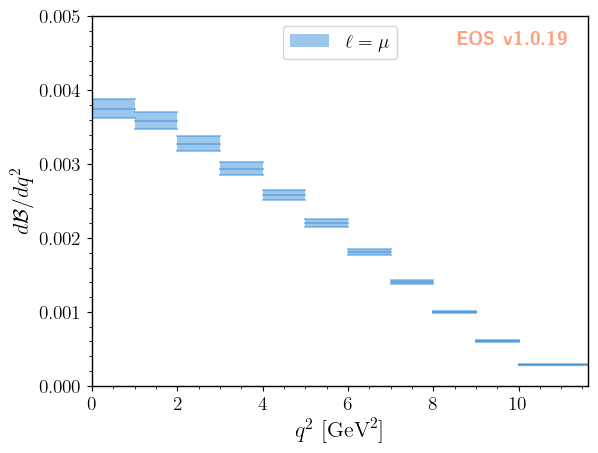

In [22]:
figure_args = """
plot:
  xaxis: { label: '$q^2$', unit: '$\\textnormal{GeV}^2$', range: [0.0, 11.63] }
  yaxis: { label: '$d\\mathcal{B}/dq^2$',                 range: [0.0,  5e-3] }
  legend: { position: 'upper center' }
  items:
    - { type: 'uncertainty-binned', label: '$\\ell=\\mu$',
        variable: 'q2', range: [0.00, 11.63],
        datafile: './predictions-base/data/FF-LQCD-SSE/pred-B-to-D-mu-nu-binned'
      }
"""
figure = eos.figure.FigureFactory.from_yaml(figure_args)
figure.draw()

For details on the plotting framework, including a list of the supported plot types, we refer to the reference part of the documentation.